In [1]:
import os
import pickle
import pandas as pd

classifiers = ["AMAXSC", "M4GP", "lda", "decision_tree", "svm_rbf", "random_forest", "MLP"]
classifier_name_map = {
    "AMAXSC": "AMAXSC",
    "M4GP": "M4GP",
    "lda": "LDA",
    "decision_tree": "Tree",
    "svm_rbf": "SVM (rbf)",
    "random_forest": "RF",
    "MLP": "MLP",
}

score_metric = "auc_score"
score_metric_index = 0 if score_metric == "auc_score" else 1

result_files = os.listdir("results")
results = []
for result_file in result_files:
    dataset, search_strategy, optimiser, random_seed = result_file.split(
        "."
    )[0].split("-")
    with open(f"results/{result_file}", "rb") as f:
        res = pickle.load(f)
    for elapsed_time, auc_score, accuracy_score in zip(res["elapsed_time"], res["auc_score"], res["accuracy_score"]):
        results.append(
            [
                dataset,
                "EDC",  # "classifier
                search_strategy,
                optimiser,
                elapsed_time,
                auc_score,
                accuracy_score,
                random_seed,
            ]
        )

result_files = os.listdir("comparison_results")
for result_file in result_files:
    dataset, classifier, random_seed = result_file.split(
        "."
    )[0].split("-")
    with open(f"comparison_results/{result_file}", "rb") as f:
        res = pickle.load(f)
    for elapsed_time, auc_score, accuracy_score in zip(res["elapsed_time"], res["auc_score"], res["accuracy_score"]):
        results.append(
            [
                dataset,
                classifier,  # "classifier
                None,
                None,
                elapsed_time,
                auc_score,
                accuracy_score,
                random_seed,
            ]
        )


df = pd.DataFrame(
    columns=[
        "dataset",
        "classifier",
        "search_strategy",
        "optimiser",
        "elapsed_time",
        "auc_score",
        "accuracy_score",
        "random_seed"
    ],
    data=results,
)

In [2]:
# Only select specific datasets
datasets = [
    "ADULT",
    "BANKNOTE",
    "BREAST",
    "CREDIT",
    "CYLINDER",
    "DIABETES",
    "HEPATITIS",
    "IONOSPHERE",
    "OCCUPANCY",
    "SONAR",
    "WISCONSIN",
]

df = df[df["dataset"].isin(datasets)]

In [3]:
grouped = df.groupby(["dataset", "classifier"])
classifiers = ["EDC", "random_forest", "logistic_regression", "svm_linear", "svm_rbf", "decision_tree"]
data_dict = {d: [0] * len(datasets) for d in classifier_name_map.values()}
for name, group in grouped:
    data_dict[classifier_name_map[name[1]]][datasets.index(name[0])] = group["auc_score"].mean()
    # print(f"{name[0]} - {name[1]} - {group['auc_score'].mean()} - {len(group)}")

data = pd.DataFrame(data_dict).rename_axis("dataset").melt(
      var_name='classifier',
      value_name='score',
      ignore_index=False,
  ).reset_index()
print(data)


    dataset classifier     score
0         0     AMAXSC  0.800314
1         1     AMAXSC  0.992542
2         2     AMAXSC  0.572839
3         3     AMAXSC  0.893512
4         4     AMAXSC  0.599814
..      ...        ...       ...
72        6        MLP  0.858333
73        7        MLP  0.973636
74        8        MLP  0.997408
75        9        MLP  0.940171
76       10        MLP  0.578109

[77 rows x 3 columns]


In [4]:
avg_rank = data.groupby('dataset').score.rank(ascending=False, pct=False).groupby(data.classifier).mean()
print(avg_rank)

classifier
AMAXSC       5.363636
LDA          3.636364
M4GP         5.681818
MLP          2.454545
RF           2.090909
SVM (rbf)    2.681818
Tree         6.090909
Name: score, dtype: float64


/home/toussaintg1/EDC-experiments/.conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


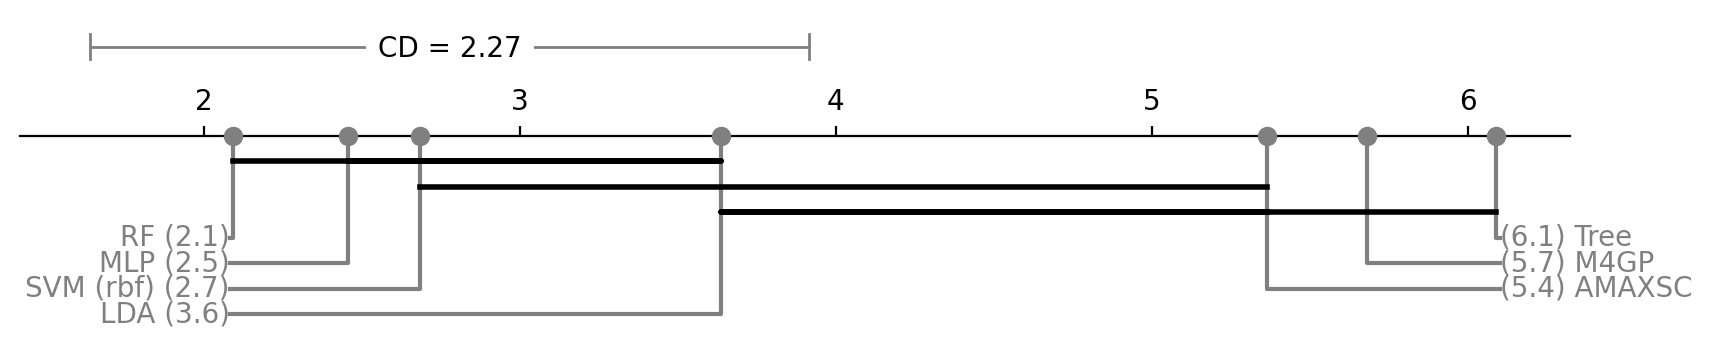

In [9]:
import matplotlib.pyplot as plt
import scikit_posthocs as sp

test_results = sp.posthoc_nemenyi_friedman(
    data,
    melted=True,
    block_col='dataset',
    group_col='classifier',
    y_col='score',
)


fig, ax = plt.subplots(
    1, 1, figsize=(10, 2), dpi=200

)
# plt.title('Critical difference diagram of average score ranks')
sp.critical_difference_diagram(
    avg_rank, test_results,
    ax=ax,
    elbow_props={'color': 'gray'}
)

critical_distance = 2.2735
start = 1.64

ax.add_line(plt.Line2D(
    [start, start], [3, 4],
    color='gray', linewidth=1, linestyle='-'
))

ax.add_line(plt.Line2D(
    [start, start + critical_distance], [3.5, 3.5],

    color='gray', linewidth=1, linestyle='-'
))

text = ax.text(
    start + critical_distance / 2, 3.1, f'CD = {critical_distance:.2f}',
    horizontalalignment='center',
)
text.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

ax.add_line(plt.Line2D(
    [start + critical_distance, start + critical_distance], [3, 4],
    color='gray', linewidth=1, linestyle='-'
))

plt.show()